# Preprocess

## Merge

In this notebook, we will create one netcdf file out of the 175 nc files retrieved from CDS. 

### Import packages

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [7]:
# ##import packages
# import os
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy
# import cartopy.crs as ccrs
# import matplotlib.ticker as mticker

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

In [9]:
# ##We want the working directory to be the UNSEEN-open directory
# pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
# pwd #print the present working directory
# os.chdir(pwd+'/../../') # Change the working directory to UNSEEN-open
# os.getcwd() #print the working directory

### Concatenate SEAS5

The SEAS5 data consists of 175 netcdf files that we downloaded from CDS ([1.2 Retrieve](reference)). We concatenate those into one netcdf file here. We create a netcdf file containing the dimensions lat, lon, number (25 ensembles), time (35 years) and leadtime (5 initialization months). To generate this, we loop over lead times, and open all 35 years of the lead time and then concatenate those leadtimes. 


In [10]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
import src.CDSretrieve as retrieve

In [11]:
os.chdir(os.path.abspath('../../../'))
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

In [19]:
import xarray as xr
import numpy as np

def merge_SEAS5(folder, target_months):
    init_months, leadtimes = retrieve._get_init_months(target_months)
    print('Lead time: ' + "%.2i" % init_months[0])
    SEAS5_ld1 = xr.open_mfdataset(
        folder + '*' + "%.2i" % init_months[0] + '.nc',
        combine='by_coords')  # Load the first lead time
    SEAS5 = SEAS5_ld1  # Create the xarray dataset to concatenate over
    for init_month in init_months[1:len(init_months)]:  ## Remove the first that we already have
        print(init_month)
        SEAS5_ld = xr.open_mfdataset(
            folder + '*' + "%.2i" % init_month + '.nc',
            combine='by_coords') 
        SEAS5 = xr.concat([SEAS5, SEAS5_ld], dim='leadtime')
    SEAS5 = SEAS5.assign_coords(leadtime = np.arange(len(init_months)) + 2) # assign leadtime coordinates
    return(SEAS5)

In [20]:
SEAS5_Siberia = merge_SEAS5(folder = '../Siberia_example/SEAS5/', target_months = [3,4,5])

Lead time: 02
1
12


In [21]:
SEAS5_Siberia
SEAS5_Siberia.sel(latitude = 60, longitude = -10, time = '2000-03', number = 24, leadtime = 3).load()

,Array,Chunk
Bytes,170.48 MB,1.62 MB
Shape,"(3, 105, 25, 41, 132)","(1, 3, 25, 41, 132)"
Count,595 Tasks,105 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,170.48 MB,1.62 MB
Shape,"(3, 105, 25, 41, 132)","(1, 3, 25, 41, 132)"
Count,595 Tasks,105 Chunks
Type,float32,numpy.ndarray


<xarray.Dataset>
Dimensions:    (time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2000-03-01
    longitude  float32 -10.0
    latitude   float32 60.0
    number     int32 24
    leadtime   int64 3
Data variables:
    t2m        (time) float32 279.34442
    d2m        (time) float32 275.4092
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-08 09:33:24 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [4]:
init_months = np.append(np.arange(9,13),1) ## Initialization months 9-12,1 (Sep-Jan)


In [8]:
SEAS5_ld1 = xr.open_mfdataset('../UK_example/SEAS5/' + '*01.nc',
                              combine='by_coords')  # Load the first lead time
SEAS5 = SEAS5_ld1  # Create the xarray dataset to concatenate over
for init_month in init_months[0:-1][::-1]:  ## Remove the first that we already have and invert so it is lead time 1-5
    print(init_month)
    SEAS5_ld = xr.open_mfdataset(
        '../UK_example/SEAS5/' + '*' + "%.2i" % init_month + '.nc',
        combine='by_coords')  # Load the first lead time to concatenate over
    SEAS5 = xr.concat([SEAS5, SEAS5_ld], dim='leadtime')

12
11
10
9


In [9]:
SEAS5 = SEAS5.assign_coords(leadtime = np.arange(5) + 2) # assign leadtime coordinates
SEAS5['tprate'] = SEAS5['tprate'] * 1000 * 3600 * 24 ## From m/s to mm/d
SEAS5['tprate'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
SEAS5
# SEAS5.load()
# SEAS5.to_netcdf('../UK_example/SEAS5/SEAS5.nc') # for future import

,Array,Chunk
Bytes,2.69 MB,15.40 kB
Shape,"(5, 35, 25, 11, 14)","(1, 1, 25, 11, 14)"
Count,1715 Tasks,175 Chunks
Type,float32,numpy.ndarray


### EOBS

I tried to download EOBS through CDS, but the Product was temporally disabled for maintenance purposes ([1.2 Retrieve](reference)). As workaround, here, I downloaded EOBS (from 1950 - 2019) and the most recent EOBS data (2020) [here](https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php). Note, you have to register as E-OBS user.

I will select February monthly mean precipitation to compare to SEAS5. I have taken the average mm/day over the month, which I think is more fair than the total monthly precipitation because of leap days. 

In [5]:
EOBS = xr.open_dataset('../UK_example/EOBS/rr_ens_mean_0.25deg_reg_v20.0e.nc') ## open the data
EOBS = EOBS.resample(time='1m').mean() ## Monthly averages
EOBS = EOBS.sel(time=EOBS['time.month'] == 2) ## Select only February
EOBS

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 70)
Coordinates:
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2019-02-28
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

Here I define the attributes, that xarray uses when plotting

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


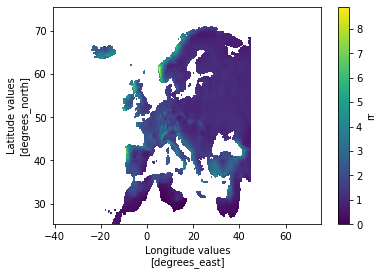

In [6]:
EOBS['rr'].attrs = {'long_name': 'rainfall',  ##Define the name
 'units': 'mm/day', ## unit
 'standard_name': 'thickness_of_rainfall_amount'} ## original name, not used
EOBS['rr'].mean('time').plot() ## and show the 1950-2019 average February precipitation 


The 2020 data file is separate and needs the same preprocessing:

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-31 2020-02-29 ... 2020-12-31
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

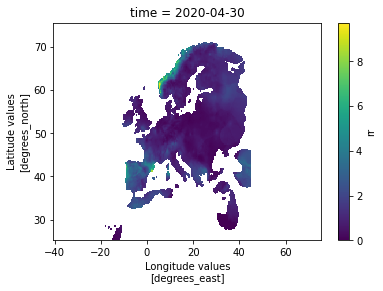

In [8]:
EOBS2020 = xr.open_dataset('../UK_example/EOBS/rr_0.25deg_day_2020_grid_ensmean.nc.1') #open
EOBS2020 = EOBS2020.resample(time='1m').mean() #Monthly mean
EOBS2020['rr'].sel(time='2020-04').plot() #show map
EOBS2020 ## display dataset

We had to download EOBS in two separate files to also obtain the 2020 data. Below, we concatenate the two files and store the processed data for easy import in the future

In [10]:
EOBS_concat = xr.concat([EOBS,EOBS2020.sel(time='2020-02')],dim='time') ## Concatenate the 1950-2019 and 2020 datasets. 
EOBS_concat.to_netcdf('../UK_example/EOBS/EOBS.nc') ## And store the 1950-2010 February precipitation into one nc for future import 